In [ ]:
import dagstermill

In [2]:
from dagster import ModeDefinition, ResourceDefinition
from collections import namedtuple

url = 'postgresql://{username}:{password}@{hostname}:5432/{db_name}'.format(
    username='test', password='test', hostname='localhost', db_name='test'
)
DbInfo = namedtuple('DbInfo', 'url')
context = dagstermill.get_context(
    mode_def=ModeDefinition(
        resource_defs={'db_info': ResourceDefinition(lambda _: DbInfo(url))}
    )
)

eastbound_delays = 'eastbound_delays'
westbound_delays = 'westbound_delays'

In [ ]:
db_url = context.resources.db_info.url

In [3]:
import math
import os

import geopandas as geo
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy as sa

from dagster.utils import mkdir_p

In [4]:
engine = sa.create_engine(db_url)

/Users/max/.virtualenvs/dagster/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
from matplotlib.backends.backend_pdf import PdfPages
plots_path = os.path.join(os.getcwd(), 'plots')
mkdir_p(plots_path)
pdf_path = os.path.join(plots_path, 'delays_by_geography.pdf')
pp = PdfPages(pdf_path)

In [6]:
westbound_delays = pd.read_sql('''
select * from {westbound_delays}
'''.format(westbound_delays=westbound_delays), engine)

In [7]:
eastbound_delays = pd.read_sql('''
select * from {eastbound_delays}
'''.format(eastbound_delays=eastbound_delays), engine)

In [8]:
states = geo.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson')

In [9]:
continental_us = states[
    states['iso_3166_2'].map(lambda x: 'HI' not in x) &
    states['iso_3166_2'].map(lambda x: 'AK' not in x)
]

In [10]:
eastbound_delays

,avg_arrival_delay,avg_departure_delay,origin,destination,num_flights,dest_latitude,dest_longitude,origin_latitude,origin_longitude
0,17.920547,20.217788,ORD,LGA,3920,40.777222,-73.872500,41.977222,-87.908056
1,12.871577,10.494684,SFO,LAX,3854,33.942500,-118.408056,37.618889,-122.375556
2,2.466523,11.422114,LAX,JFK,3288,40.640000,-73.778611,33.942500,-118.408056
3,2.800473,7.676788,LAX,LAS,2986,36.080000,-115.152222,33.942500,-118.408056
4,0.535376,10.021526,LGA,BOS,2730,42.363056,-71.006389,40.777222,-73.872500
5,3.635118,14.077778,ATL,LGA,2454,40.777222,-73.872500,33.636667,-84.427778
6,8.034824,11.445015,ATL,MCO,2347,28.429444,-81.308889,33.636667,-84.427778
7,7.529049,11.019273,ATL,FLL,2287,26.071667,-80.149722,33.636667,-84.427778
8,1.089863,3.661355,SEA,LAX,2264,33.942500,-118.408056,47.450000,-122.311667
9,-1.401453,8.381210,LAX,DEN,2224,39.861667,-104.673056,33.942500,-118.408056


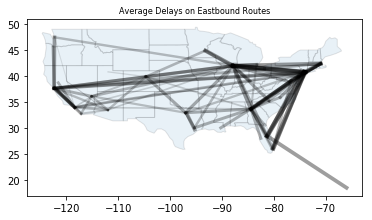

In [11]:
ax = continental_us.plot(
    alpha=0.1,
    edgecolor='black',
)
# These "should" be great circles, but to keep the demo dependencies lightweight we aren't using basemap
for i in eastbound_delays.index:
    if eastbound_delays['avg_arrival_delay'][i] > 1:
        plt.plot(
            (eastbound_delays['origin_longitude'][i], eastbound_delays['dest_longitude'][i]),
            (eastbound_delays['origin_latitude'][i], eastbound_delays['dest_latitude'][i]),
            'k-',
            linewidth=math.sqrt(eastbound_delays['avg_arrival_delay'][i]),
            alpha=min(math.sqrt(eastbound_delays['avg_arrival_delay'][i]) * .1, 1)
        )
plt.title('Average Delays on Eastbound Routes', fontsize=8)
pp.savefig()

In [12]:
westbound_delays

,avg_arrival_delay,avg_departure_delay,origin,destination,num_flights,dest_latitude,dest_longitude,origin_latitude,origin_longitude
0,12.425526,18.464770,LGA,ORD,3918,41.977222,-87.908056,40.777222,-73.872500
1,10.403037,12.776862,LAX,SFO,3849,37.618889,-122.375556,33.942500,-118.408056
2,-5.560342,7.309851,JFK,LAX,3288,33.942500,-118.408056,40.640000,-73.778611
3,4.208628,8.485175,LAS,LAX,2985,33.942500,-118.408056,36.080000,-115.152222
4,3.697084,11.359758,BOS,LGA,2730,40.777222,-73.872500,42.363056,-71.006389
5,-1.819496,9.400823,LGA,ATL,2455,33.636667,-84.427778,40.777222,-73.872500
6,5.628106,8.688623,MCO,ATL,2349,33.636667,-84.427778,28.429444,-81.308889
7,10.342394,13.147484,FLL,ATL,2288,33.636667,-84.427778,26.071667,-80.149722
8,2.763821,4.163572,LAX,SEA,2265,47.450000,-122.311667,33.942500,-118.408056
9,5.986943,11.954545,DEN,LAX,2232,33.942500,-118.408056,39.861667,-104.673056


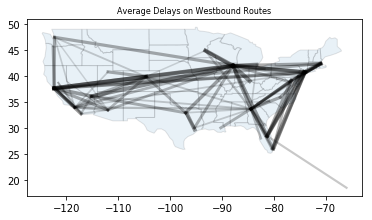

In [13]:
ax = continental_us.plot(
    alpha=0.1,
    edgecolor='black',
)
# These "should" be great circles, but to keep the demo dependencies lightweight we aren't using basemap
for i in westbound_delays.index:
    if westbound_delays['avg_arrival_delay'][i] > 1:
        plt.plot(
            (westbound_delays['origin_longitude'][i], westbound_delays['dest_longitude'][i]),
            (westbound_delays['origin_latitude'][i], westbound_delays['dest_latitude'][i]),
            'k-',
            linewidth=math.sqrt(westbound_delays['avg_arrival_delay'][i]),
            alpha=min(math.sqrt(westbound_delays['avg_arrival_delay'][i]) * .1, 1)
        )
plt.title('Average Delays on Westbound Routes', fontsize=8)
pp.savefig()

In [14]:
pp.close()

In [15]:
from dagster import LocalFileHandle
dagstermill.yield_result(LocalFileHandle(pdf_path))

'/Users/max/dev/dagster/python_modules/airline-demo/airline_demo/notebooks/plots/delays_by_geography.pdf'